# Single-cell RNA-seq with `scanpy`. Part 1

Prepared with scanpy documentation, tutorials and best practices

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns
from scipy.stats import median_abs_deviation

import matplotlib.pyplot as plt

import igraph
import leidenalg

import celltypist
from celltypist import models, annotate

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [3]:
#path to file
current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'archive', 'GSM3681518_MNC_RNA_counts.tsv', 
                                   'citeseq_rna_counts.tsv')

file_path_to_df = os.path.abspath(file_path)

## 1. Reading the data. 

We need to transpose the table to make sure that rows (observations) contain cells and columns (variables) contain genes

In [4]:
#read rna seq data
adata = sc.read_csv(filename=file_path_to_df, delimiter='\t')
adata = adata.T
adata

AnnData object with n_obs × n_vars = 33454 × 17009

In [5]:
print("Number of cells:", adata.n_obs)
print("Number of genes:", adata.n_vars)
print("Total UMI counts:", adata.X.sum()) #Unique Molecular Identifier counts

Number of cells: 33454
Number of genes: 17009
Total UMI counts: 99561200.0


# 2. QC

Let’s assemble some information about mitochondrial genes, which are important for quality control.

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

## Perform basic filtration

In [6]:
print("Cells before:", adata.shape[0])
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("Cells after:", adata.shape[0])

Cells before: 33454
filtered out 6 cells that have less than 200 genes expressed
filtered out 1 genes that are detected in less than 3 cells
Cells after: 33448


Data description:

- `a_AAACCTGAGCTTATCG.1 ` cell barcode

- `n_genes` number of genes with at least 1 read transcript 

- `n_genes_by_counts` the number of genes with positive counts in a cell

- `log1p_n_genes_by_counts` log(1 + n_genes_by_counts) - for logarithmic normalization

- `total_counts` the total number of counts for a cell, this might also be known as library size

- `log1p_total_counts` log(1 + total_counts) - logarithm

- `pct_counts_in_top_50_genes` % of transcripts, per 50 most active genes

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs.head()  

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
a_AAACCTGAGCTTATCG.1,2136,2136,7.667158,7546.0,8.928905,39.716406,55.883912,64.908561,75.496952
a_AAACCTGAGGTGGGTT.1,437,437,6.082219,1029.0,6.937314,50.340136,65.792031,76.967930,100.000000
a_AAACCTGAGTACATGA.1,429,429,6.063785,1111.0,7.013916,54.545455,69.396940,79.387939,100.000000
a_AAACCTGCAAACCTAC.1,851,851,6.747587,2741.0,7.916443,50.492521,65.268150,74.863189,87.194455
a_AAACCTGCAAGGTGTG.1,843,843,6.738152,2099.0,7.649693,40.447832,54.168652,66.936636,83.658885


As we can see, the function added a couple of additional columns to .var and .obs. Let's add percent of mitochondrial genes:

In [8]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

Draw the scatterplots of some variables

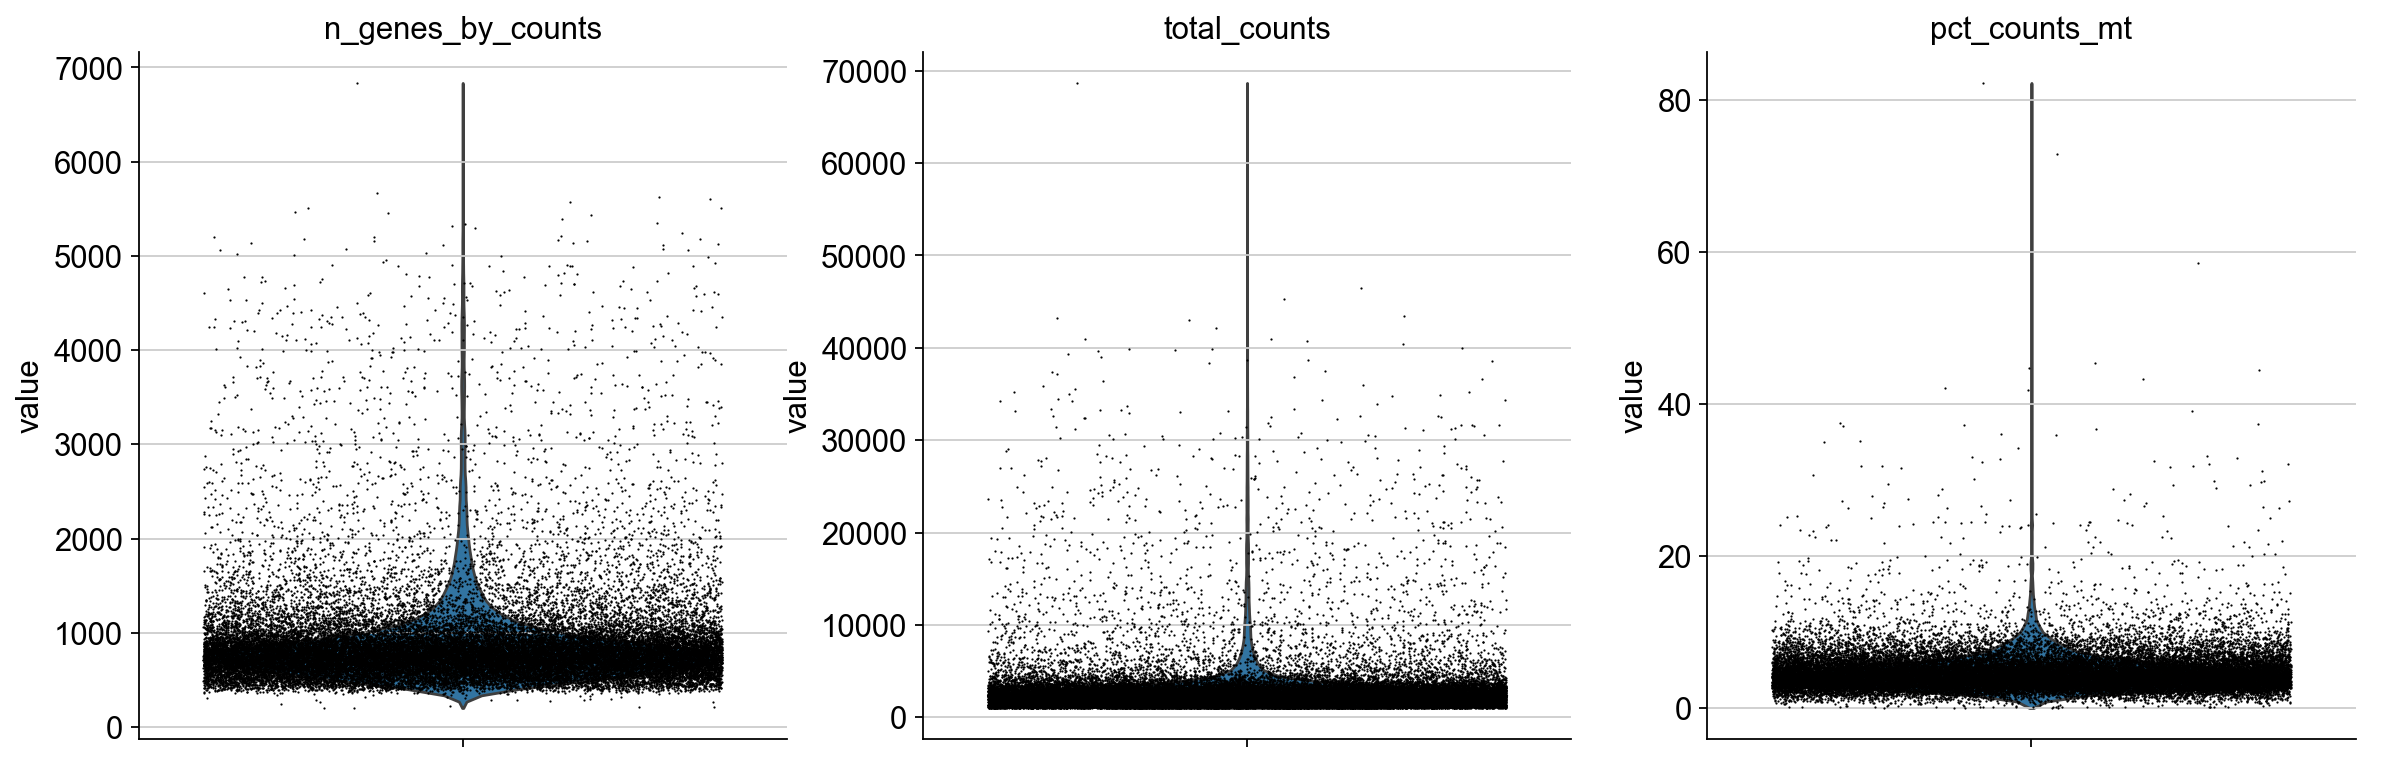

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

* The `n_genes_by_counts` metric shows the number of genes with positive counts in a cell. Outliers at the bottom of the graph are usually empty droplets. Outliers at the top of the graph are doublets or artifacts

* The metric `total_counts` shows the total number of counts for a cell, this may also be known as library size. Too low values indicate incomplete cells, and too high values indicate doublets or technical artifacts

* The `pct_counts_mt` metric shows the fraction of mitochondrial transcripts (%). If the metric is more than 20%, the cell is damaged

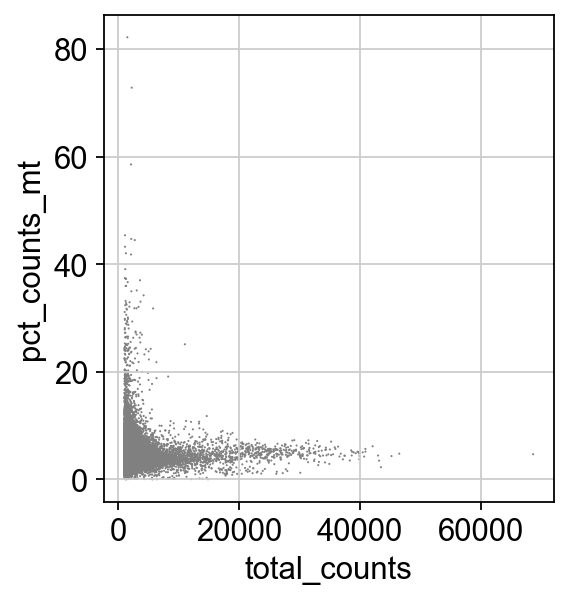

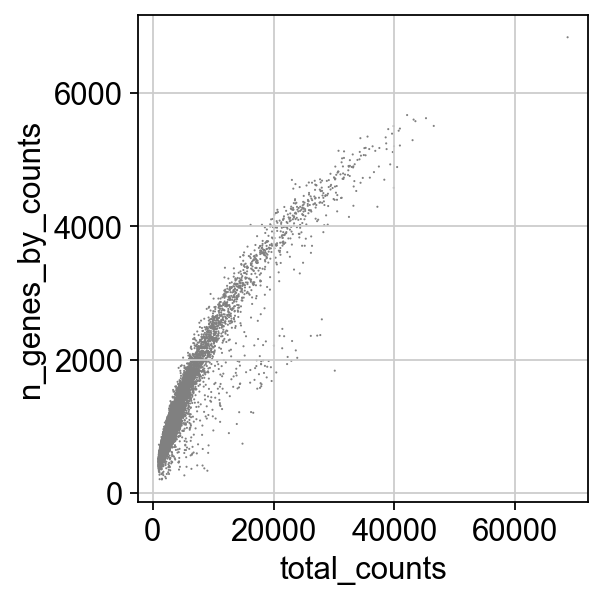

In [10]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

We now filter our AnnData object based on condition: pct_counts_mt more than 10 and n_genes_by_counts more than 6000 and total_counts more than 40000. Because immune cells need to be active and synthesize a lot of proteins. 

In [11]:
adata = adata[adata.obs.pct_counts_mt < 10, :]
print(f'After filtering by pct_counts_mt:{adata.shape[0]}')
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
print(f'After filtering by n_genes_by_counts:{adata.shape[0]}')
adata = adata[adata.obs.total_counts < 40000, :]
print(f'After filtering by total_counts:{adata.shape[0]}')

After filtering by pct_counts_mt:32497
After filtering by n_genes_by_counts:32496
After filtering by total_counts:32486


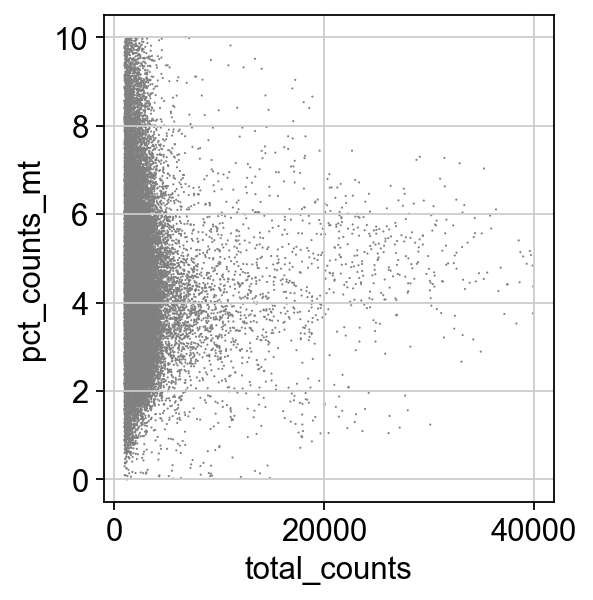

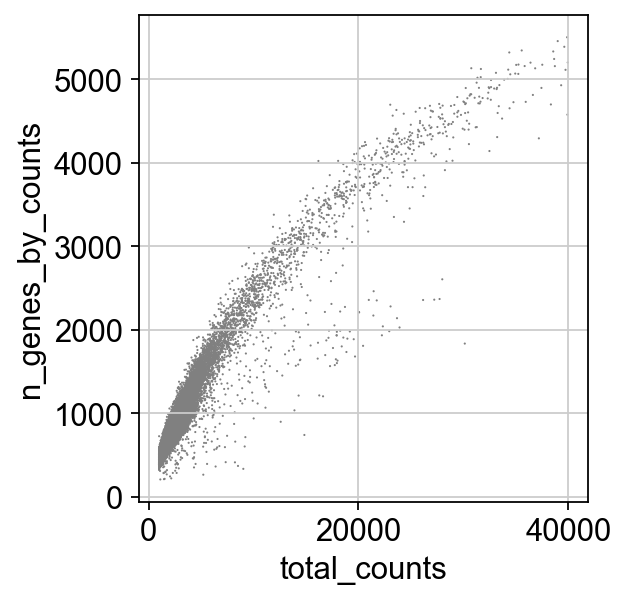

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

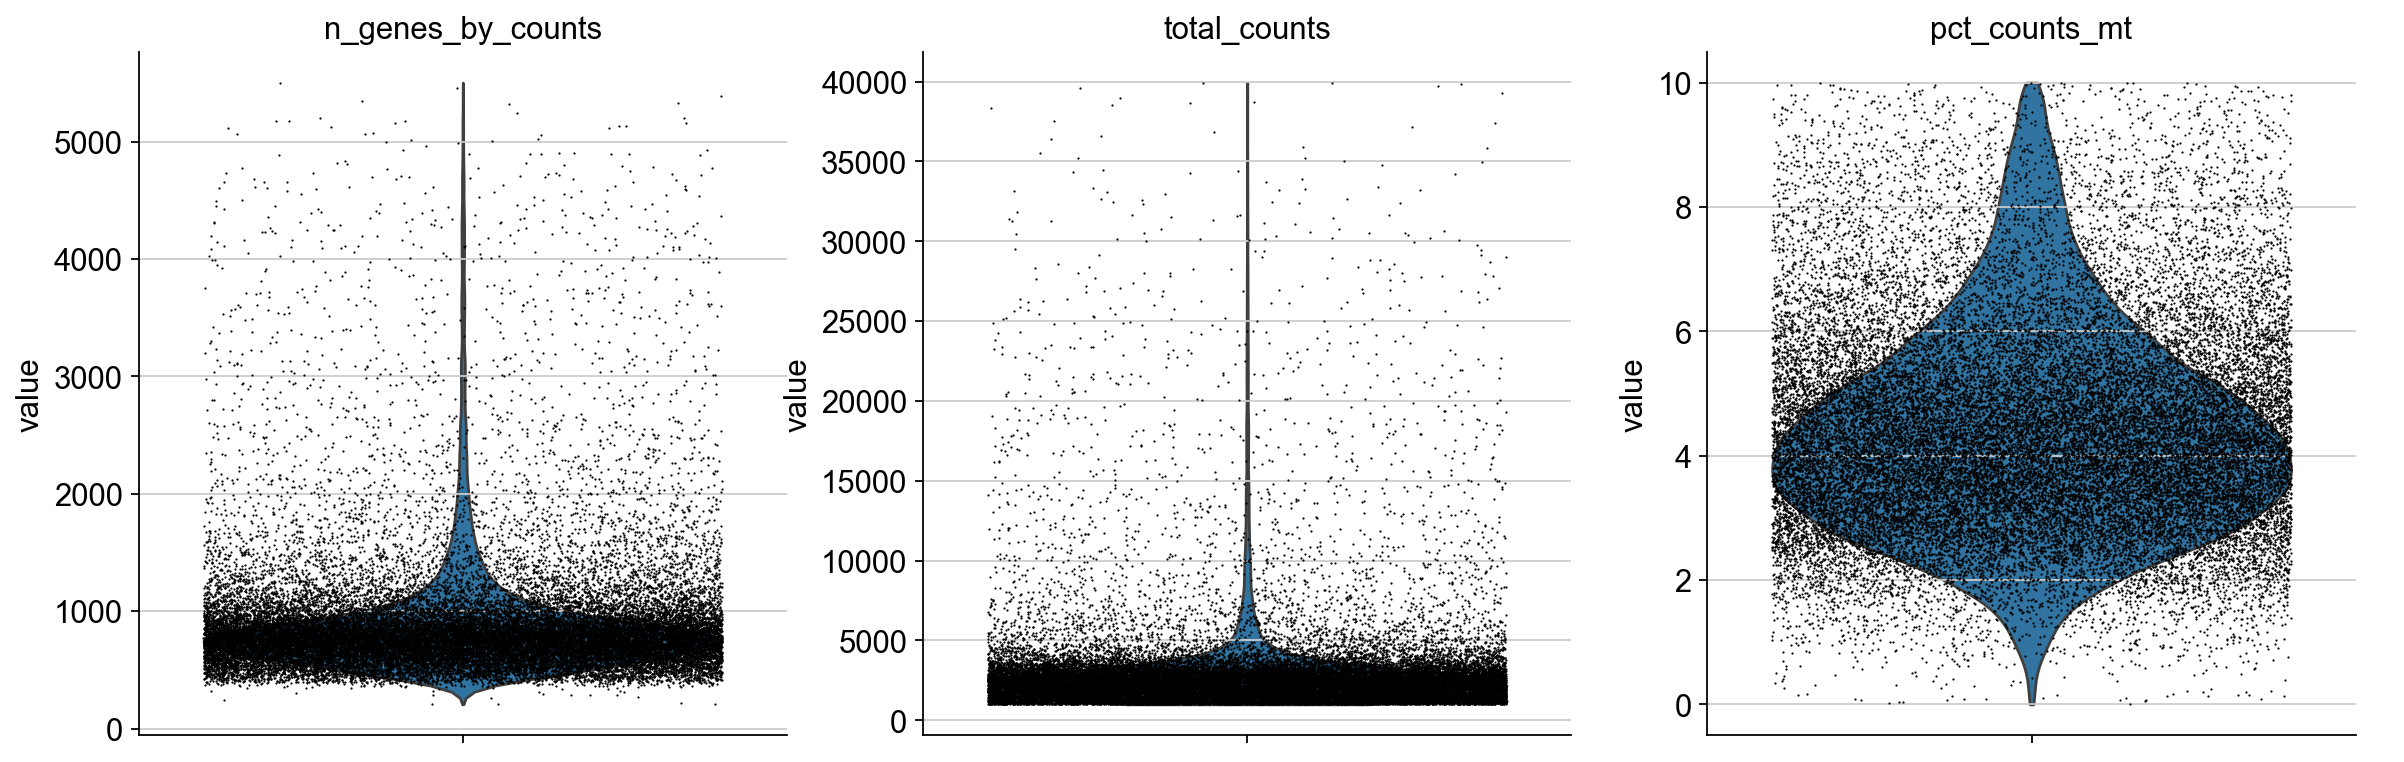

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Cells before: 33454. Cells after filtering: 32486

Filtered 968 cells

Also save our data before transformation:

In [12]:
adata.raw = adata.copy()

## Data normalization

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Logarithmize the data.

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [14]:
print("before normalization:")
print(f"min: {adata.raw.X.min()}, max: {adata.raw.X.max()}")

print("\nafter normalization + log")
print(f"min: {adata.X.min()}, max: {adata.X.max()}")

before normalization:
min: 0.0, max: 15147.0

after normalization + log
min: 0.0, max: 8.96036434173584


## Identify highly-variable genes

One main analysis step for single-cell data is to identify highly-variable genes (HVGs) and perform feature selection to reduce the dimensionality of the dataset. HVGs are genes which show significantly different expression profiles between cells or distinct groups.

Parameters:

- `mean` is the average expression of a gene. The minimum value should weed out genes that are null in expression, and the maximum value should weed out housekeeping genes, of which there are many everywhere

- `disp` variance, 0.0125/3/0.5 default values

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Number of highly variable genes: 1803


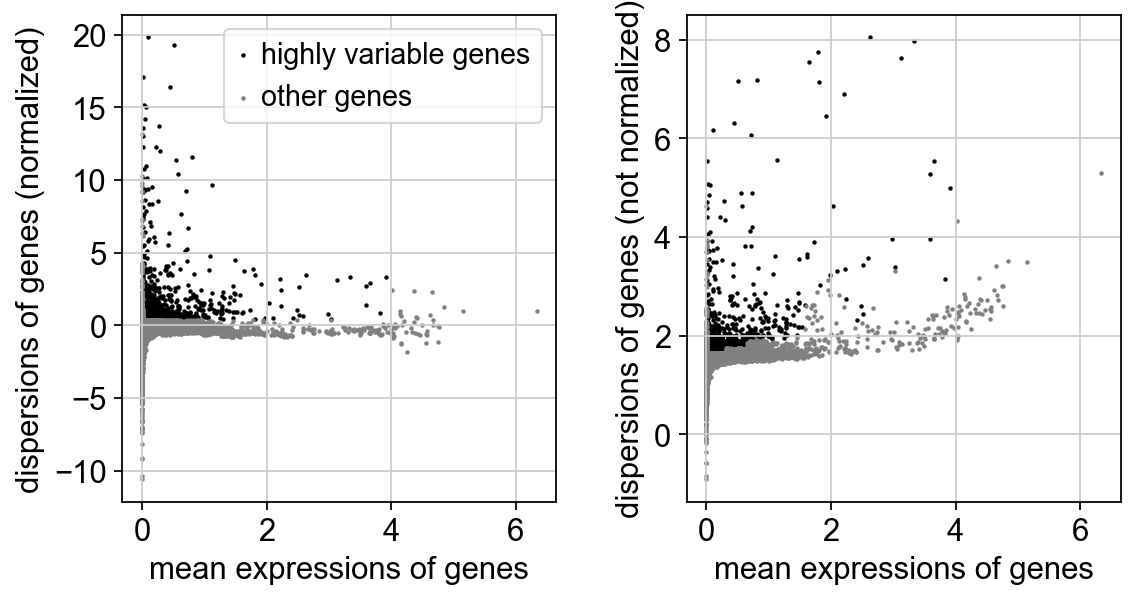

In [15]:
sc.pp.highly_variable_genes(
    adata, 
    min_mean=0.01, 
    max_mean=4, 
    min_disp=0.4
)

print(f'Number of highly variable genes: {adata.var['highly_variable'].sum()}')

sc.pl.highly_variable_genes(adata)

normalizing counts per cell
    finished (0:00:00)


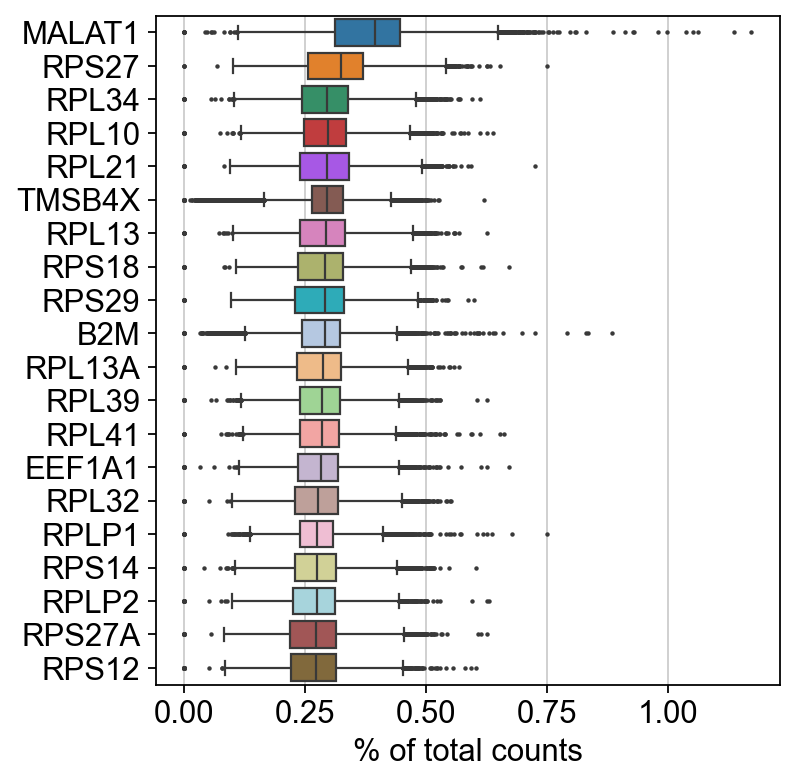

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

## PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data

- `svd_solver='arpack'` for the ARPACK wrapper in SciPy (svds()). Not available with dask arrays.

In [17]:
sc.pp.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:02)


Let's look at the proportion of variance explained by the components:

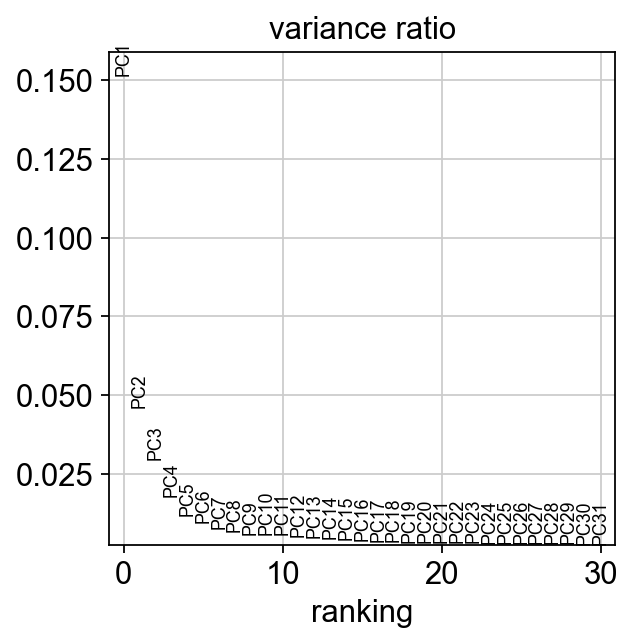

In [18]:
sc.pl.pca_variance_ratio(adata)

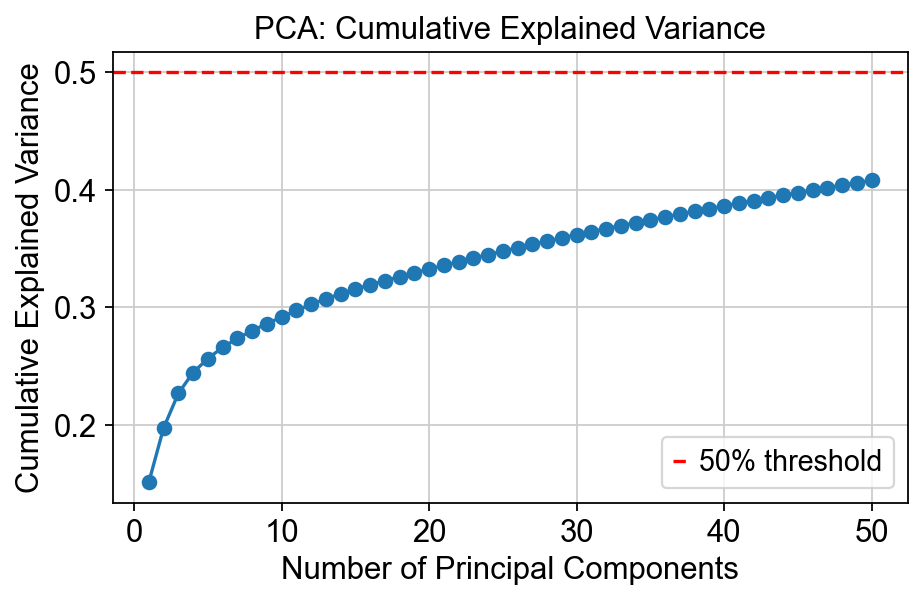

In [19]:
explained_variance = adata.uns['pca']['variance_ratio']

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

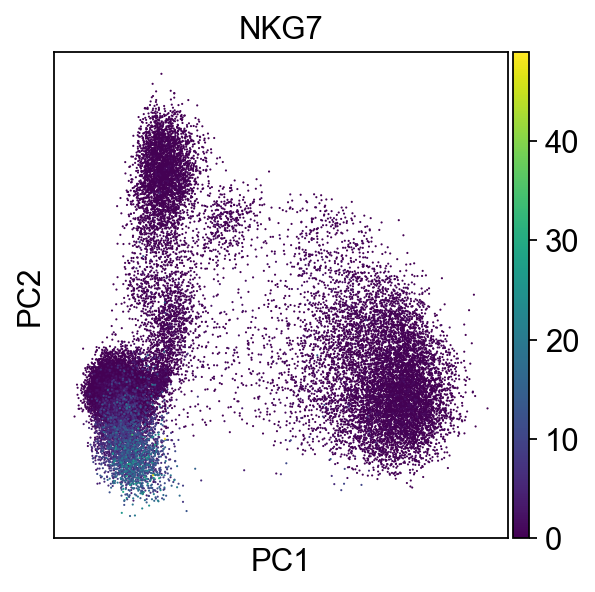

In [20]:
sc.pl.pca(adata, color="NKG7")

Save results:

In [21]:
results_file = "pbmc_citeseq_results.h5ad"
adata.write(results_file)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix.

`n_neighbours` affects the number of clusters

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30


c:\Users\LOLpm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)


## Clustering cells

To cluster the cells, we use the Leiden graph-clustering method. This will directly cluster the neighborhood graph of cells computed above. 

In [23]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


Partition-based graph abstraction (PAGA) generates a much simpler abstracted graph (PAGA graph) of partitions, in which edge weights represent confidence in the presence of connections. By thresholding this confidence in paga(), a much simpler representation of the manifold data is obtained, which is nonetheless faithful to the topology of the manifold

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


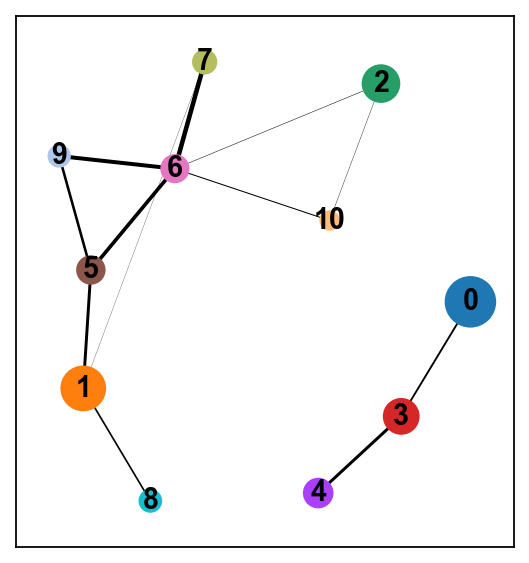

computing UMAP


In [24]:
sc.tl.paga(adata)
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

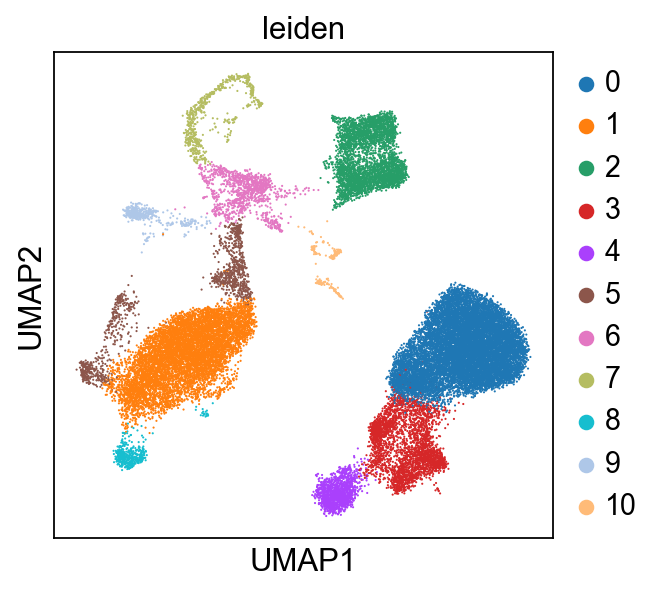

In [25]:
sc.pl.umap(adata, color=['leiden'])

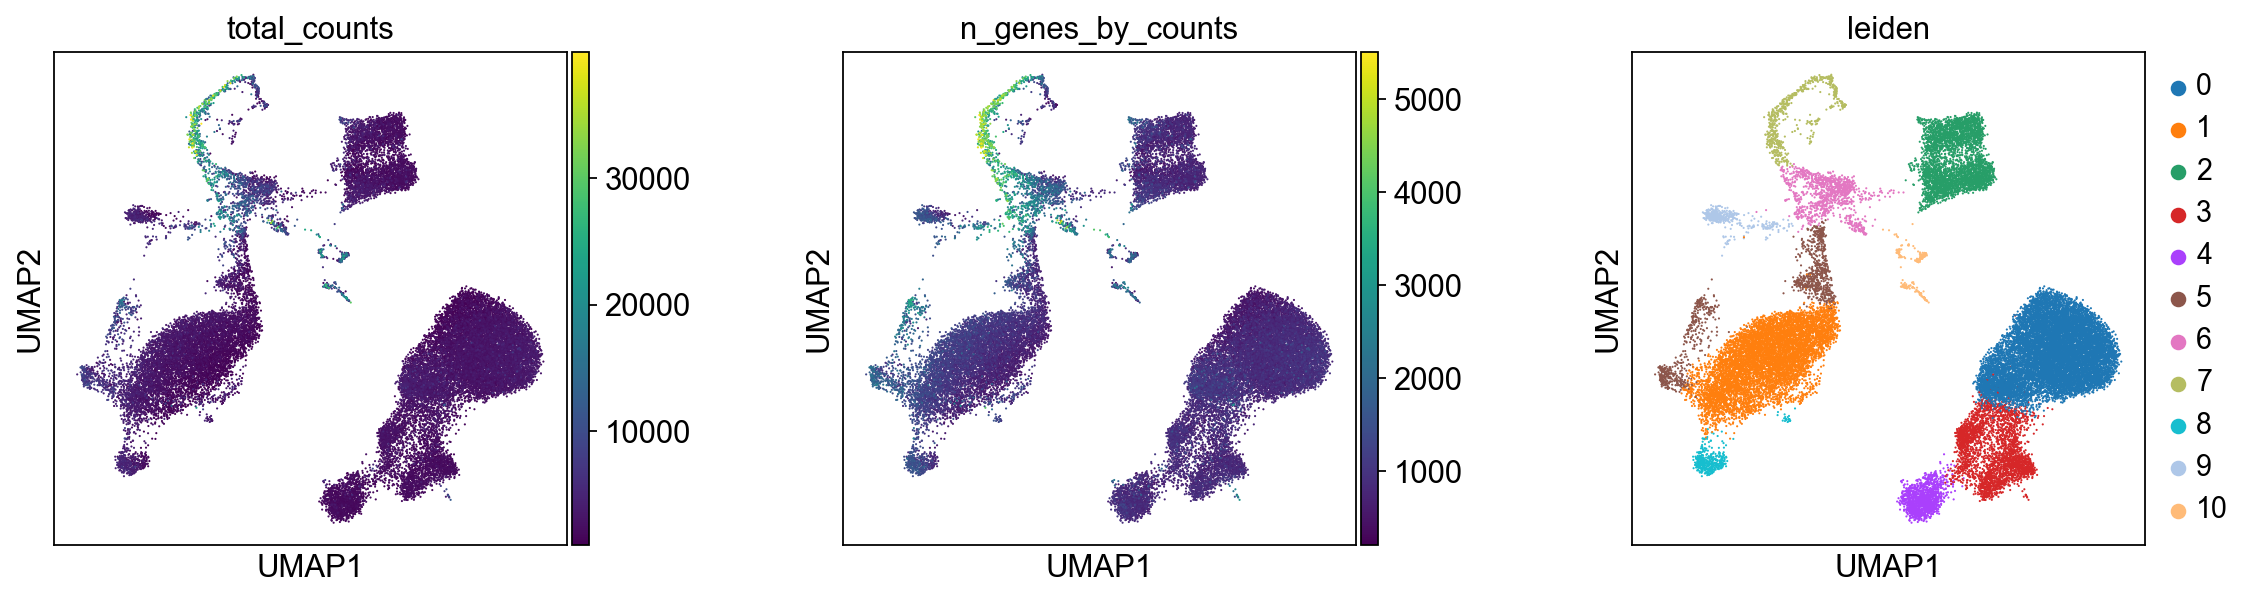

In [31]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)